In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import uxarray as ux
import intake
import healpix as hp
import holoviews as hv

import hvplot.pandas  # noqa
import hvplot.dask  # noqa

hvplot.extension('matplotlib')

import easygems.healpix as eghp

import cmocean
import geoviews.feature as gf


def get_nest(ds):
    return ds.crs.healpix_order == "nest"
    
def get_nside(ds):
    return ds.crs.healpix_nside

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

rda_scratch = '/glade/derecho/scratch/khirata/'

cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 32,
    memory = '1024GiB',
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=32:mem=256GB',
    queue = 'casper',
    walltime = '7:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

# cluster.scale(5)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34813 instead
  warnings.warn(
/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (21.26s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/khirata/hackathon-casper/proxy/34813/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/khirata/hackathon-casper/proxy/34813/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.122:40891,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/khirata/hackathon-casper/proxy/34813/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
def read_nc_freq(fn_nc, varname='pr'):
    uxds_freq_f = xr.open_dataset(fn_nc)
    frequency_f_tmp = uxds_freq_f[varname].compute()
    frequency_f_tmp = frequency_f_tmp.astype('float64')
    ds = frequency_f_tmp.to_dataset()
    ds = ds.swap_dims({'n_face': 'cell'})
    frequency_from_file = ux.UxDataset.from_healpix(ds)[varname]
    return frequency_from_file

In [133]:
# Load the NetCDF file
rda_scratch = '/glade/derecho/scratch/khirata/'

frequency_um_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_um_v4_juan.nc', 'pr')
frequency_scream_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_scream.nc', 'pr')
frequency_icon_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_icon.nc', 'pr')
frequency_nicam_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_nicam.nc', 'pr')
frequency_mpas_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_mpas.nc', 'rainnc')
frequency_cas_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_cas_MAYBE.nc', 'pr')
frequency_ew_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_ew.nc', 'pr')
# frequency_imerg_from_file = read_nc_freq(rda_scratch + 'IR_IMERG_mo_freq_2020.nc', 'precipitation')
frequency_imerg_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_imerg_test2.nc', 'precipitation')


### Old
# uxds_freq_um = xr.open_dataset(rda_scratch + 'frequency_gt_1mm_um.nc') # change the path if needed!!
# frequency_um_tmp = uxds_freq_um['pr'].compute()
# frequency_um_tmp = frequency_um_tmp.astype('float64')
# ds = frequency_um_tmp.to_dataset()
# ds = ds.swap_dims({'n_face': 'cell'})
# frequency_um_from_file = ux.UxDataset.from_healpix(ds)['pr']

In [52]:
freq_era5 = xr.open_dataset('/glade/u/home/patnaude/HK25/ERA5_Feb_precfreq.nc')


In [69]:
freq_era5

<xarray.Dataset> Size: 8MB
Dimensions:                        (lat: 721, lon: 1440)
Coordinates:
  * lat                            (lat) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * lon                            (lon) float64 12kB 0.0 0.25 ... 359.5 359.8
    month                          int64 8B ...
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 8MB 0.0 0.0 ... 0.0 0.0

In [114]:
freq_era5['__xarray_dataarray_variable__']

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 721, lon: 1440)> Size: 8MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(721, 1440))
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    month    int64 8B 2

In [134]:
from matplotlib.colors import Normalize
from matplotlib import colors as mcolors
import hvplot.xarray
from holoviews.plotting.mpl import MPLPlot
MPLPlot.sublabel_format = ""

hv.extension('matplotlib')

month = 2

plot_args = {
    'backend': 'matplotlib',
    'projection': ccrs.Robinson(),
    'figsize': (8, 8),
    'coastline': True,
    'land': True,
    'ocean': True,
    'grid': True,
    'cmap': cmocean.cm.ice_r,
    'colorbar': False,
    'clim': (0, 1),
    # 'sublabel_size': 0,
}

all_plots = (
 frequency_scream_from_file.sel(month=2).plot(title='SCREAM', colorbar_position='bottom', **plot_args)
+ frequency_icon_from_file.sel(month=2).plot(title='ICON', colorbar_position='bottom', **plot_args)
+ frequency_nicam_from_file.sel(month=2).plot(title='NICAM', colorbar_position='bottom', **plot_args)
+ frequency_um_from_file.sel(month=2).plot(title='UM', colorbar_position='bottom', **plot_args)
+ frequency_ew_from_file.sel(month=2).plot(title='EW', colorbar_position='bottom', **plot_args)
+ frequency_mpas_from_file.sel(month=2).plot(title='MPAS', colorbar_position='bottom', **plot_args)
+ frequency_cas_from_file.sel(month=2).plot(title='CAS', colorbar_position='bottom', **plot_args)
+ frequency_imerg_from_file.sel(month=2).plot(title='IMERG', colorbar_position='bottom', **plot_args)
+ freq_era5['__xarray_dataarray_variable__'].hvplot(title='ERA5', colorbar_position='bottom', rasterize=True, **plot_args)
).cols(3)

# # ax9 = fig.add_subplot(3, 3, 9)

In [107]:
hv.save(all_plots, 'frequency_plots.png', dpi=300)

RuntimeError: To use bokeh.io image export functions you need selenium ('conda install selenium' or 'pip install selenium')

:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude pr)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude pr)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude pr)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude pr)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.V    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude pr)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VI   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude rainnc)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VII  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude pr)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VIII :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude precipitation)
      .Coastline.I :Feature   [Longitude,Latitude]
   .DynamicMap.I :DynamicMap   []
      :Overlay
         .Image.I     :Image   [lon,lat]   (__xarray_dataarray_variable__)
         .Coastline.I :Feature   [Longitude,Latitude]
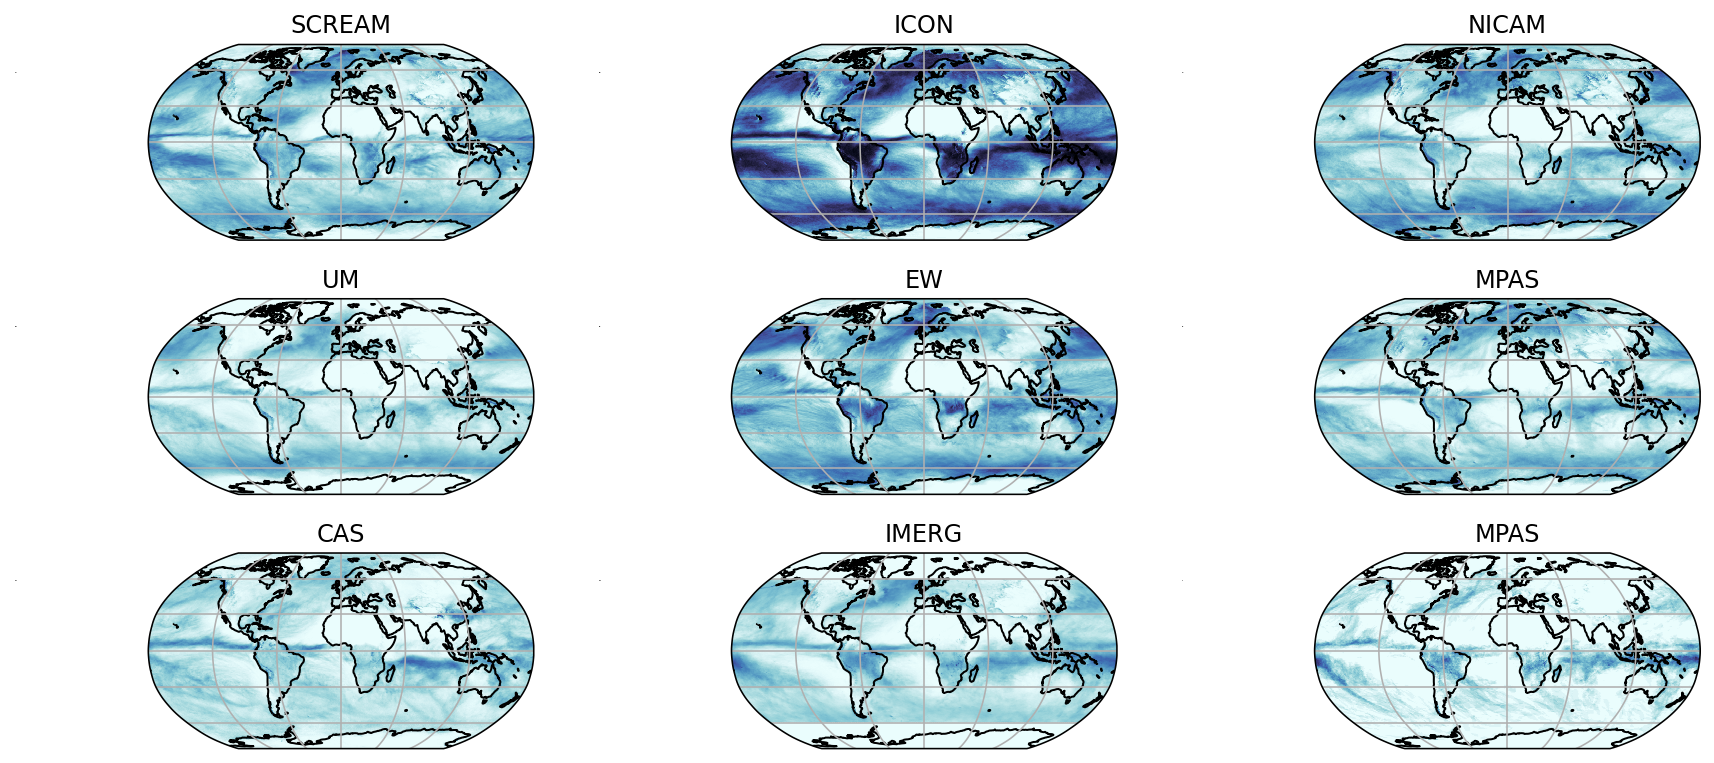

In [135]:
all_plots.opts(
    sublabel_size=0,
    # fig_size=(16, 10),
    # height=300,
    # width=500,
    # colorbar=False,
)

In [61]:
%matplotlib inline

month = 2

projection = ccrs.Robinson()

pc_scream = frequency_scream_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")
pc_um = frequency_um_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")
pc_icon = frequency_icon_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")
pc_nicam = frequency_nicam_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")
pc_mpas = frequency_mpas_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")
pc_cas = frequency_cas_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")
pc_imerg = frequency_imerg_from_file.sel(month=month).to_polycollection(projection=projection, override=True, cmap="PuBu")



TypeError: _AxesBase.add_collection() got an unexpected keyword argument 'vmin'

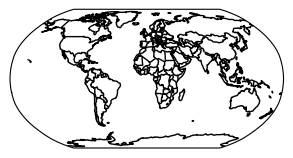

In [ ]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson())
ax1.set_global()
ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.BORDERS)
ax1.add_collection(pc_scream, vmin=0, vmax=1)
ax1.set_title('SCREAM')

ax2 = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson())
ax2.set_global()
ax2.add_feature(cf.COASTLINE)
ax2.add_feature(cf.BORDERS)
# ax2.add_collection(pc_um, vmin=0, vmax=1)
ax2.set_title('UM')

ax3 = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson())
ax3.set_global()
ax3.add_feature(cf.COASTLINE)
ax3.add_feature(cf.BORDERS)
# ax3.add_collection(pc_icon, vmin=0, vmax=1)
ax3.set_title('ICON')

ax4 = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson())
ax4.set_global()
ax4.add_feature(cf.COASTLINE)
ax4.add_feature(cf.BORDERS)
# ax4.add_collection(pc_nicam, vmin=0, vmax=1)
ax4.set_title('NICAM')

ax5 = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson())
ax5.set_global()
ax5.add_feature(cf.COASTLINE)
ax5.add_feature(cf.BORDERS)
# ax5.add_collection(pc_mpas, vmin=0, vmax=1)
ax5.set_title('MPAS')

ax6 = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson())
ax6.set_global()
ax6.add_feature(cf.COASTLINE)
ax6.add_feature(cf.BORDERS)
# ax6.add_collection(pc_cas, vmin=0, vmax=1)
ax6.set_title('CAS')

ax7 = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson())
ax7.set_global()
ax7.add_feature(cf.COASTLINE)
ax7.add_feature(cf.BORDERS)
xx, yy = np.meshgrid(freq_era5['lon'], freq_era5['lat'])
mappable = ax7.pcolormesh(xx, yy, freq_era5['__xarray_dataarray_variable__'], cmap="PuBu", vmin=0, vmax=1, transform=ccrs.PlateCarree())
ax7.set_title('ERA5')

ax8 = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson())
ax8.set_global()
ax8.add_feature(cf.COASTLINE)
ax8.add_feature(cf.BORDERS)
# ax8.add_collection(pc_imerg, vmin=0, vmax=1)
ax8.set_title('IMERG')


TypeError: 'UxDataArray' object is not callable

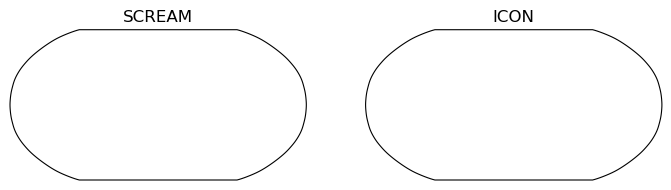

In [ ]:
# %matplotlib inline

# import numpy as np

# month = 2


# # pr_freq_scream = (uxda_pr_scream > threshold).groupby("time.month").mean("time")
# # pr_freq_icon   = (uxda_pr_icon > threshold).groupby("time.month").mean("time")
# # pr_freq_nicam  = (uxda_pr_nicam > threshold).groupby("time.month").mean("time")
# # pr_freq_imerg  = (uxda_pr_imerg > threshold).groupby("time.month").mean("time")

# # fig, axes = plt.subplots(3, 3, figsize=(13, 7), subplot_kw={'projection': ccrs.Robinson()})
# fig = plt.figure(figsize=(13, 7))

# ax1 = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson())
# ax1.set_global()
# ax1.set_title("SCREAM")
# frequency_scream_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_scream_from_file.sel(month=month), ax=ax1, cmap="PuBu", vmin=0, vmax=1)
# ax1.add_feature(cf.COASTLINE, linewidth=0.8)
# ax1.add_feature(cf.BORDERS, linewidth=0.4)

# ax2 = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson())
# ax2.set_global()
# ax2.set_title("ICON")
# frequency_icon_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_icon_from_file.sel(month=month), ax=ax2, cmap="PuBu", vmin=0, vmax=1)
# ax2.add_feature(cf.COASTLINE, linewidth=0.8)
# ax2.add_feature(cf.BORDERS, linewidth=0.4)

# ax3 = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson())
# ax3.set_global()
# ax3.set_title("NICAM")
# frequency_nicam_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_nicam_from_file.sel(month=month), ax=ax3, cmap="PuBu", vmin=0, vmax=1)
# ax3.add_feature(cf.COASTLINE, linewidth=0.8)
# ax3.add_feature(cf.BORDERS, linewidth=0.4)

# ax4 = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson())
# ax4.set_global()
# ax4.set_title("MPAS")
# frequency_mpas_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_mpas_from_file.sel(month=month), ax=ax4, cmap="PuBu", vmin=0, vmax=1)
# ax4.add_feature(cf.COASTLINE, linewidth=0.8)
# ax4.add_feature(cf.BORDERS, linewidth=0.4)

# ax5 = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson())
# ax5.set_global()
# ax5.set_title("UM")
# frequency_um_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_um_from_file.sel(month=month), ax=ax5, cmap="PuBu", vmin=0, vmax=1)
# ax5.add_feature(cf.COASTLINE, linewidth=0.8)
# ax5.add_feature(cf.BORDERS, linewidth=0.4)

# ax6 = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson())
# ax6.set_global()
# ax6.set_title("CAS")
# frequency_cas_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_cas_from_file.sel(month=month), ax=ax6, cmap="PuBu", vmin=0, vmax=1)
# ax6.add_feature(cf.COASTLINE, linewidth=0.8)
# ax6.add_feature(cf.BORDERS, linewidth=0.4)

# ax7 = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson())
# ax7.set_global()
# ax7.set_title("IMERG")
# frequency_imerg_from_file(month=month).plot()
# # mappable = eghp.healpix_show(frequency_imerg_from_file.sel(month=month), ax=ax7, cmap="PuBu", vmin=0, vmax=1)
# ax7.add_feature(cf.COASTLINE, linewidth=0.8)
# ax7.add_feature(cf.BORDERS, linewidth=0.4)

# ax8 = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson())
# ax8.set_global()
# ax8.set_title("ERA5")
# xx, yy = np.meshgrid(freq_era5['lon'], freq_era5['lat'])
# mappable = ax8.pcolormesh(xx, yy, freq_era5['__xarray_dataarray_variable__'], cmap="PuBu", vmin=0, vmax=1, transform=ccrs.PlateCarree())
# ax8.add_feature(cf.COASTLINE, linewidth=0.8)
# ax8.add_feature(cf.BORDERS, linewidth=0.4)

# # Add a colorbar at the bottom edge of the plot, spanning all columns
# cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.025])  # [left, bottom, width, height]
# fig.colorbar(
#     mappable, cax=cbar_ax, orientation='horizontal', label="Precipitation Frequency (>1 mm)"
# )

# fig.suptitle(f"Precipitation Frequency (month={month})", fontsize=16)
# # /

# # fig.colorbar(
# #     mappable_imerg, ax=axes[1, 1], orientation='horizontal', shrink=0.7, pad=0.05,
#     # label="Precipitation Frequency Difference"
# # )
# # plt.tight_layout()

In [128]:
lon_bounds = (-180, 180)
lat_bounds = (-65, 65)
freq_imerg_m = frequency_imerg_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds)
freq_dif_scream = frequency_scream_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds) - freq_imerg_m
freq_dif_icon = frequency_icon_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds) - freq_imerg_m
freq_dif_nicam = frequency_nicam_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds) - freq_imerg_m
freq_dif_mpas = frequency_mpas_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds) - freq_imerg_m
freq_dif_um = frequency_um_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds) - freq_imerg_m
freq_dif_cas = frequency_cas_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds) - freq_imerg_m
# freq_imerg_m = frequency_imerg_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'})
# freq_dif_scream = frequency_scream_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'}) - freq_imerg_m
# freq_dif_icon = frequency_icon_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'}) - freq_imerg_m
# freq_dif_nicam = frequency_nicam_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'}) - freq_imerg_m
# freq_dif_mpas = frequency_mpas_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'}) - freq_imerg_m
# freq_dif_um = frequency_um_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'}) - freq_imerg_m
# freq_dif_cas = frequency_cas_from_file.sel(month=month).subset.bounding_box(lon_bounds, lat_bounds).swap_dims({'n_face': 'cell'}).set_index({'cell': 'cell'}) - freq_imerg_m

KeyboardInterrupt: 

In [1]:
%matplotlib inline

month = 2

# pr_freq_scream = (uxda_pr_scream > threshold).groupby("time.month").mean("time")
# pr_freq_icon   = (uxda_pr_icon > threshold).groupby("time.month").mean("time")
# pr_freq_nicam  = (uxda_pr_nicam > threshold).groupby("time.month").mean("time")
# pr_freq_imerg  = (uxda_pr_imerg > threshold).groupby("time.month").mean("time")

# fig, axes = plt.subplots(3, 3, figsize=(13, 7), subplot_kw={'projection': ccrs.Robinson()})
fig = plt.figure(figsize=(10, 9))

ax1 = fig.add_subplot(3, 2, 1, projection=ccrs.Robinson())
ax1.set_global()
ax1.set_title("SCREAM")
freq_dif_scream.plot()
# mappable = eghp.healpix_show(freq_dif_scream, ax=ax1, cmap="seismic", vmin=-1, vmax=1)
ax1.add_feature(cf.COASTLINE, linewidth=0.8)
ax1.add_feature(cf.BORDERS, linewidth=0.4)

ax2 = fig.add_subplot(3, 2, 2, projection=ccrs.Robinson())
ax2.set_global()
ax2.set_title("ICON")
freq_dif_icon.plot()
# mappable = eghp.healpix_show(freq_dif_icon, ax=ax2, cmap="seismic", vmin=-1, vmax=1)
ax2.add_feature(cf.COASTLINE, linewidth=0.8)
ax2.add_feature(cf.BORDERS, linewidth=0.4)

ax3 = fig.add_subplot(3, 2, 3, projection=ccrs.Robinson())
ax3.set_global()
ax3.set_title("NICAM")
freq_dif_nicam.plot()
mappable = eghp.healpix_show(freq_dif_nicam, ax=ax3, cmap="seismic", vmin=-1, vmax=1)
ax3.add_feature(cf.COASTLINE, linewidth=0.8)
ax3.add_feature(cf.BORDERS, linewidth=0.4)

ax4 = fig.add_subplot(3, 2, 4, projection=ccrs.Robinson())
ax4.set_global()
ax4.set_title("MPAS")
freq_dif_mpas.plot()
mappable = eghp.healpix_show(freq_dif_mpas, ax=ax4, cmap="seismic", vmin=-1, vmax=1)
ax4.add_feature(cf.COASTLINE, linewidth=0.8)
ax4.add_feature(cf.BORDERS, linewidth=0.4)


ax5 = fig.add_subplot(3, 2, 5, projection=ccrs.Robinson())
ax5.set_global()
ax5.set_title("UM")
freq_dif_um.plot()
mappable = eghp.healpix_show(freq_dif_um, ax=ax5, cmap="seismic", vmin=-1, vmax=1)
ax5.add_feature(cf.COASTLINE, linewidth=0.8)
ax5.add_feature(cf.BORDERS, linewidth=0.4)

ax6 = fig.add_subplot(3, 2, 6, projection=ccrs.Robinson())
ax6.set_global()
ax6.set_title("CAS")
freq_dif_cas.plot()
mappable = eghp.healpix_show(freq_dif_cas, ax=ax6, cmap="seismic", vmin=-1, vmax=1)
ax6.add_feature(cf.COASTLINE, linewidth=0.8)
ax6.add_feature(cf.BORDERS, linewidth=0.4)

# Add a colorbar at the bottom edge of the plot, spanning all columns
cbar_ax = fig.add_axes([0.35, 0.08, 0.3, 0.02])  # [left, bottom, width, height]
fig.colorbar(
    mappable, cax=cbar_ax, orientation='horizontal', label="Precipitation Frequency (>1 mm)"
)

fig.suptitle(f"Precipitation Frequency (month={month})", fontsize=16)


# fig.colorbar(
#     mappable_imerg, ax=axes[1, 1], orientation='horizontal', shrink=0.7, pad=0.05,
    # label="Precipitation Frequency Difference"
# )
# plt.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
month = 2

frequency_zm_scream   = frequency_scream_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_icon     = frequency_icon_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_nicam    = frequency_nicam_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_um       = frequency_um_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_ew       = frequency_ew_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_mpas     = frequency_mpas_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_cas      = frequency_cas_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_imerg    = frequency_imerg_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_era5     = freq_era5['__xarray_dataarray_variable__'].mean(dim='lon')

ValueError: freq must be an object of type 'str', 'datetime.timedelta', 'pandas.Timedelta', 'pandas.DateOffset', or 'TimeResampler'. Received <class 'tuple'> instead.

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[-85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0
   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90] [ 90.    89.75  89.5   89.25  89.    88.75  88.5   88.25  88.    87.75
  87.5   87.25  87.    86.75  86.5   86.25  86.    85.75  85.5   85.25
  85.    84.75  84.5   84.25  84.    83.75  83.5   83.25  83.    82.75
  82.5   82.25  82.    81.75  81.5   81.25  81.    80.75  80.5   80.25
  80.    79.75  79.5   79.25  79.    78.75  78.5   78.25  78.    77.75
  77.5   77.25  77.    76.75  76.5   76.25  76.    75.75  75.5   75.25
  75.    74.75  74.5   74.25  74.    73.75  73.5   73.25  73.    72.75
  72.5   72.25  72.    71.75  71.5   71.25  71.    70.75  70.5   70.25
  70.    69.75  69.5   69.25  69.    68.75  68.5   68.25  68.    67.75
  67.5   67.25  67.    66.75  66.5   66.25  66.    65.75  65.5   65

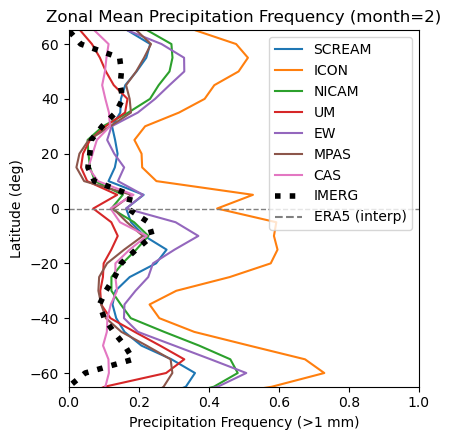

In [175]:
%matplotlib inline

import numpy as np

# Interpolate ERA5 zonal mean to match IMERG latitudes
frequency_zm_era5_interp = np.interp(
    np.array(frequency_zm_imerg.latitudes.values),
    np.array(frequency_zm_era5['lat'].values),
    np.array(frequency_zm_era5.values),
    left=np.nan,
    right=np.nan
)
print(frequency_zm_era5_interp)
print(np.array(frequency_zm_imerg.latitudes.values),
    np.array(frequency_zm_era5['lat'].values),
    np.array(frequency_zm_era5.values))

plt.figure(figsize=(4.5, 4.5))

plt.plot(frequency_zm_scream, frequency_zm_scream.latitudes, label="SCREAM")
plt.plot(frequency_zm_icon, frequency_zm_icon.latitudes, label="ICON")
plt.plot(frequency_zm_nicam, frequency_zm_nicam.latitudes, label="NICAM")
plt.plot(frequency_zm_um, frequency_zm_um.latitudes, label="UM")
plt.plot(frequency_zm_ew, frequency_zm_ew.latitudes, label="EW")
plt.plot(frequency_zm_mpas, frequency_zm_mpas.latitudes, label="MPAS")
plt.plot(frequency_zm_cas, frequency_zm_cas.latitudes, label="CAS")
plt.plot(frequency_zm_imerg, frequency_zm_imerg.latitudes,  linestyle='dotted', label="IMERG", color="k", linewidth=4)
plt.plot(frequency_zm_era5_interp, frequency_zm_imerg.latitudes, linestyle='dashed', label="ERA5 (interp)", color="gray")
# plt.plot(frequency_zm_era5, frequency_zm_era5.lat, linestyle='dashed', label="ERA5", color="gray")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Precipitation Frequency (>1 mm)")
plt.ylabel("Latitude (deg)")
plt.title(f"Zonal Mean Precipitation Frequency (month={month})")
plt.xlim(0, 1)
plt.ylim(-65, 65)
plt.legend()
plt.tight_layout()
plt.show()


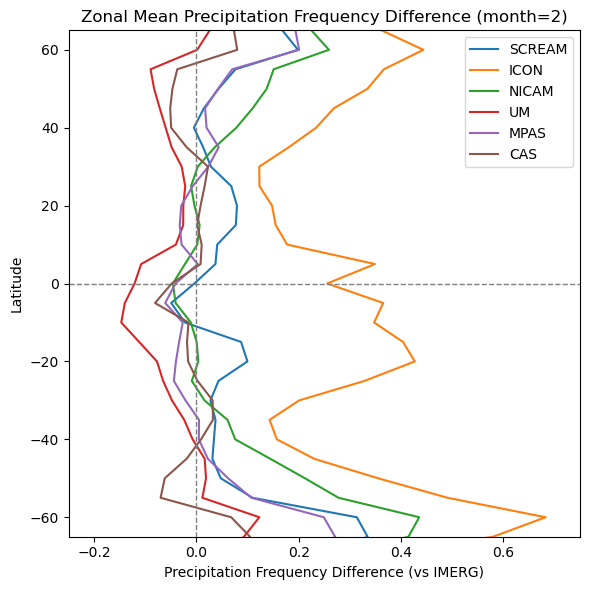

In [ ]:
%matplotlib inline

plt.figure(figsize=(6, 6))

plt.plot(frequency_zm_scream - frequency_zm_imerg, frequency_zm_scream.latitudes, label="SCREAM")
plt.plot(frequency_zm_icon - frequency_zm_imerg, frequency_zm_icon.latitudes, label="ICON")
plt.plot(frequency_zm_nicam - frequency_zm_imerg, frequency_zm_nicam.latitudes, label="NICAM")
plt.plot(frequency_zm_um - frequency_zm_imerg, frequency_zm_um.latitudes, label="UM")
plt.plot(frequency_zm_mpas - frequency_zm_imerg, frequency_zm_mpas.latitudes, label="MPAS")
plt.plot(frequency_zm_cas - frequency_zm_imerg, frequency_zm_cas.latitudes, label="CAS")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)


plt.xlabel("Precipitation Frequency Difference (vs IMERG)")
plt.ylabel("Latitude")
plt.title(f"Zonal Mean Precipitation Frequency Difference (month={month})")
plt.xlim(-0.25, 0.75)
plt.ylim(-65, 65)
plt.legend()
plt.tight_layout()
plt.show()